In [1]:
import pickle
import sys
sys.path.insert(0,'../code/')
from shared import *
import pandas as pd

In [2]:
K = 5
F = 5
results_km = defaultdict(dict)
features_km = defaultdict(dict)
for k in range(2, K+1):
    with open(f'../results/kmeans/rawresults/result_{k}{F}.pickle','rb') as p:
        ti,t = pickle.load(p)
    for f in range(2, F+1):
            results_km[k][f] = t[f-2]
    for f in range(2,F+1):
            features_km[k][f] = ti[f-2]

tracts = features_km[2][2][0].index.values.tolist()

results_mp = defaultdict(dict)
features_mp = defaultdict(dict)
for k in range(2, K+1):
    with open(f'../results/milp/rawresults/result_{k}{F}.pickle','rb') as p:
        ti,(tc,tb) = pickle.load(p)
    for f in range(2, F+1):
            results_mp[k][f] = (tc[f-2],tb[f-2])
    for f in range(2,F+1):
            features_mp[k][f] = ti[f-2]

In [3]:
from collections import Counter
Counter(features_mp[5][5].model.values)

Counter({1: 46, 2: 48, 5: 56, 3: 33, 4: 53})

In [4]:
results_mp[5][5]

(  feature  Cluster1  Cluster2  Cluster3  Cluster4  Cluster5
 0    prof  0.519719  0.110296  0.734264  0.298900       0.0
 1     col  0.190684  0.000000  1.472848  0.000000       0.0
 2   flabf  0.000000  0.000000  0.000000  0.271225       0.0
 3   multi  0.000000  0.778089  0.301736  0.317434       0.0
 4     own  0.000000  2.039449  0.985028  0.313829       0.0,
 [0.14908337428950225,
  0.0,
  0.552169732458759,
  0.000782654643833593,
  0.013422061198145485])

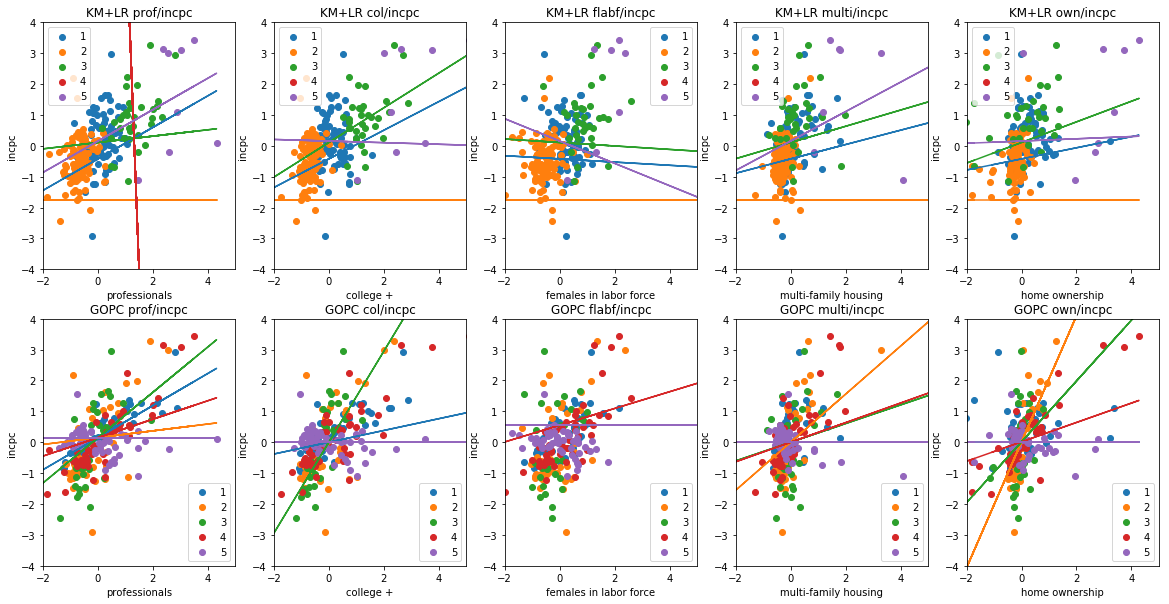

In [12]:
F = 5
K = 5
df = features_km[K][F][0]
plt.subplots(2,5,figsize=(20,10))
for i in range(F):
    plt.subplot(2,5,i+1)
    vals = df.iloc[:,i].values
    for j in range(K):
        r = results_km[K][F][j]
        r_coef = r.coef_[0,i]
        r_bias = r.intercept_[0]
        plt.plot(vals, (vals*r_coef) + r_bias)
        plt.scatter(
            df[df.model == j+1].iloc[:,i].values,
            df[df.model == j+1].incpc.values,
            label = f'{j+1}'
        )
    plt.xlabel(names[df.iloc[:,i].name])
    plt.ylabel('incpc')
    plt.xlim(-2,5)
    plt.ylim(-4,4)
    plt.legend()
    plt.title(f'KM+LR {df.iloc[:,i].name}/incpc')
df = features_mp[K][F]
for i in range(F):
    plt.subplot(2,5,i+6)
    vals = df.iloc[:,i].values
    for j in range(K):
        r = results_mp[K][F]
        r_coef = r[0].iloc[:,j+1].values[i]
        r_bias = r[1][i]
        plt.plot(vals, (vals*r_coef) + r_bias)
        plt.scatter(
            df[df.model == j+1].iloc[:,i].values,
            df[df.model == j+1].incpc.values,
            label = f'{j+1}'
        )
    plt.xlabel(names[df.iloc[:,i].name])
    plt.ylabel('incpc')
    plt.xlim(-2,5)
    plt.ylim(-4,4)
    plt.legend()
    plt.title(f'GOPC {df.iloc[:,i].name}/incpc')

plt.savefig('kmeans_single_feature_plot.pdf')

In [11]:
names = {
    'prof':'professionals',
    'col':'college +',
    'flabf':'females in labor force',
    'multi':'multi-family housing',
    'own':'home ownership'
}

In [6]:
average_values = {}
piecewise_data = pd.read_csv(filepath+"NY_2000_NEW.csv")
# calculate MI with respect ot the label and rank them
output = piecewise_data.set_index('trtid')
miScoredf = getMI(output, 'incpc')
miScoredf = miScoredf.sort_values(by=['MI'], ascending=False)
# number of features to keep (by highest MI)
keep_feature = miScoredf[:5].feature.values
for k,fs in results_km.items():
    average_values[k] = {}
    for f, rs in fs.items():
        average_values[k][f] = {}
        for m,model in enumerate(rs):
            average_values[k][f][m+1] = dict(zip(keep_feature,model.coef_[0]))


In [12]:
readindata_std('incpc',5).columns.values[1:-1]

array(['prof', 'col', 'flabf', 'multi', 'own'], dtype=object)

In [13]:
av = pd.DataFrame()
av['k'] = 0
av['f'] = 0
for k in average_values[5][5][1].keys():
    av[k] = ''
n = []
for k, fs in average_values.items():
    for f, ms in fs.items():
        assignments = defaultdict(list)
        for v,tk in (zip(
            features_km[
                k][
                f][0].index.values.tolist(),
            features_km[k
                   ][
                f][0]['model'].values.tolist())):
            assignments[tk].append(v)
        for m, cs in ms.items():
            t = {
                'k':k,
                'f':f,
            }
            for c, v in cs.items():
                t[c] = v
            for col in av.columns:
                if col not in t.keys():
                    t[col] = 'N/A'
            t['assignments'] = assignments[m]
            t['model'] = m
            n.append(t)
av = pd.DataFrame(n)
print(av.columns)
av = av[['k','f','model','prof', 'col', 'flabf', 'multi', 'own','assignments']]
av.to_csv('/home/alex/Desktop/kmeans_weight_averages.csv')

Index(['assignments', 'col', 'f', 'flabf', 'k', 'model', 'multi', 'own',
       'prof'],
      dtype='object')


In [14]:
av = av[['k','f','model','prof', 'col', 'flabf', 'multi', 'own','assignments']]
av.to_csv('/home/alex/Desktop/kmeans_weight_averages.csv')
av

,k,f,model,prof,col,flabf,multi,own,assignments
0,2,2,1,0.408608,0.254685,N/A,N/A,N/A,"[36061000201, 36061000202, 36061000600, 360610..."
1,2,2,2,0.278777,0.367237,N/A,N/A,N/A,"[36061001402, 36061001501, 36061001800, 360610..."
2,2,3,1,0.534572,0.251978,-0.302397,N/A,N/A,"[36061001200, 36061001402, 36061001501, 360610..."
3,2,3,2,0.325236,0.459805,-0.123707,N/A,N/A,"[36061000201, 36061000202, 36061000600, 360610..."
4,2,4,1,0.456950,0.305338,-0.259767,-0.0253737,N/A,"[36061000201, 36061000202, 36061000600, 360610..."
5,2,4,2,0.333988,0.339930,-0.232691,0.249508,N/A,"[36061001200, 36061001402, 36061001501, 360610..."
6,2,5,1,0.447673,0.274370,-0.266519,-0.0405042,0.0746739,"[36061001200, 36061001402, 36061001501, 360610..."
7,2,5,2,0.280231,0.350854,-0.250466,0.145941,0.142835,"[36061000201, 36061000202, 36061000600, 360610..."
8,3,2,1,0.601805,-0.189453,N/A,N/A,N/A,"[36061001002, 36061001200, 36061001402, 360610..."
9,3,2,2,-0.195801,0.757822,N/A,N/A,N/A,"[36061002400, 36061013500, 36061015602, 360610..."


In [15]:
bv = []
features = ['prof', 'col', 'flabf', 'multi', 'own','incpc']
for i in range(len(av)):
    t = {}
    k = av.iat[i,0]
    f = int(av.iat[i,1])
    d = readindata_std('incpc',f)
    model = av.iat[i,2]
    assignments = av.iat[i,8]
    fdict = defaultdict(list)
    for asmt in assignments:
        for feat in features[0:f]:
            fdict[feat].append(
                d[d.trtid == asmt][feat].values[0]
            )
        fdict['incpc'].append(
            d[d.trtid == asmt]['incpc'].values[0]
        )
    for feat in features:
        t[feat] = np.mean(fdict[feat])
    t['k'] = k
    t['f'] = f
    t['model'] = av.iat[i,2]
    bv.append(t)
bv = pd.DataFrame(bv)

In [16]:
bv = bv[['k','f','model','prof', 'col', 'flabf', 'multi', 'own','incpc']]
bv.to_csv('/home/alex/Desktop/kmeans_feature_averages.csv')

In [17]:
bv

,k,f,model,prof,col,flabf,multi,own,incpc
0,2,2,1,-0.471227,-0.476878,NaN,NaN,NaN,-0.298743
1,2,2,2,1.213767,1.228322,NaN,NaN,NaN,0.769491
2,2,3,1,0.943705,0.943137,0.771895,NaN,NaN,0.631143
3,2,3,2,-0.581736,-0.581386,-0.475826,NaN,NaN,-0.389061
4,2,4,1,-0.543600,-0.531986,-0.424833,-0.259164,NaN,-0.364241
5,2,4,2,1.040223,1.017999,0.812953,0.495931,NaN,0.697004
6,2,5,1,1.024521,0.992867,0.801658,0.480832,0.443286,0.695434
7,2,5,2,-0.555786,-0.538614,-0.434886,-0.260843,-0.240475,-0.377262
8,3,2,1,0.516852,0.494584,NaN,NaN,NaN,0.346797
9,3,2,2,2.299353,2.301482,NaN,NaN,NaN,1.549862
